# Dog-Breed-Classification 

## Overview

The goal of this project is to provide a working prototype of a system which is capable of discriminating between dogs and humans. System shouldn't just choose between two classes `dog` and `human` but also return `none` class for each different image it classifies. 

If image is labeled as `dog` or `human`, the system should provide next classification which is an assigment of the post similar `dog-breed` class to the given image.

There is no minimum requirement of how many types of dog breeds the system needs to support.

## Problem Statement

Project can be divided into following steps.

#### Data

Udacity has provided following datasets for building the prototype:

- AIND Dogs, 8351 images, https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

- AIND Humans, 13233 images, https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

Small self-made dataset containing 20 testing images (5 dogs, 5 humans, 10 non-dogs & non-humans).
- link: https://www.dropbox.com/s/qdam34r8x0lajc7/test_images.zip?dl=1

#### Finding best human detector
Model or vision system capable of determining whether human is on image or not. 

#### Finding best dog detector
Model or vision system capable of determining whether dog is on image or not.

#### Finding best dog-breed detector
Model or vision system capable of attaching most similar dog-breed to given image.

#### System assembly
There is no single way of completing this task. The system could be either system combining outputs of 3 models or for example: one model detecting dogs and humans on the image and returning probability of being either of them for both. If probability would be below threshold then system would return `none` class, otherwise system would return either `dog` or `human` class. Then the image would be directed to next model, which determines `dog-breed`.

-----
Transfer learning will greatly improve performance of all detectors.

## Metrics

As this is classification problem, proper metrics to assess the system capabilities should be either `accuracy` and/or `f1-score`.

## Machine

Project is prepared on my local machine equipped with: `GeForce GTX 1070Ti` (https://www.nvidia.com/pl-pl/geforce/products/10series/geforce-gtx-1070/)

# Code

## Import

In [1]:
import time
import os
import shutil
import random
import zipfile
import warnings
import urllib.request
from glob import glob
from copy import deepcopy
from collections import Counter

import cv2
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.datasets import load_files 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input

from keras.preprocessing import image
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint  
from keras.engine import  Model

%matplotlib inline

Using TensorFlow backend.


## Constant

In [2]:
GLOBAL_SEED = 300919902019

DATA_DIR = os.path.join("data")

AIND_DOG_URL = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"
AIND_DOG_DIR = os.path.join(DATA_DIR, "aind_dog_images")
AIND_DOG_CLASSES_NUM = 133

AIND_HUMAN_DIR = os.path.join("data", "aind_human_images")
AIND_HUMAN_URL = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip"

TEST_IMAGES_DIR = os.path.join("data", "test_images")
TEST_IMAGES_URL = "https://www.dropbox.com/s/qdam34r8x0lajc7/test_images.zip?dl=1"

OPENCV_HAAR_CASCADES_DIR = "haarcascades"
OPENCV_GIT_BASEPATH = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/"
OPENCV_HAAR_CASCADES = {
    "haarcascade_frontalcatface.xml": OPENCV_GIT_BASEPATH + "haarcascade_frontalcatface.xml",
    "haarcascade_frontalcatface_extended.xml": OPENCV_GIT_BASEPATH + "haarcascade_frontalcatface_extended.xml",
    "haarcascade_frontalface_alt.xml": OPENCV_GIT_BASEPATH + "haarcascade_frontalcatface_extended.xml",
    "haarcascade_frontalface_alt2.xml": OPENCV_GIT_BASEPATH + "haarcascade_frontalface_alt2.xml",
    "haarcascade_frontalface_alt_tree.xml": OPENCV_GIT_BASEPATH + "haarcascade_frontalface_alt_tree.xml",
    "haarcascade_frontalface_default.xml": OPENCV_GIT_BASEPATH + "haarcascade_frontalface_default.xml"
}

SAVED_MODELS_DIR = "saved_models"

PREDICTOR_TYPE_HUMAN = "human"
PREDICTOR_TYPE_DOG = "dog"
PREDICTOR_TYPE_DOG_BREED = "dog_breed"

## Predictor

In [3]:
predictors = {
    PREDICTOR_TYPE_HUMAN: {},
    PREDICTOR_TYPE_DOG: {},
    PREDICTOR_TYPE_DOG_BREED: {}
}

In [4]:
class Predictor:
    """Class for normalizing API for each model type. It is capable of making 
    predictions on data."""
    
    def __init__(self, predictor, label, **kwargs):
        """Constructor for predictor class.

        Parameters:
        -----------
        predictor: function
            Function taking two arguments: (img: str), (kwargs: **kwargs). It uses model 
            stored in 'kwargs' and it's preprocessing functions to load image based on 
            'img' filepath and returns prediction.
        label: str
            Description for stored model.
        kwargs: **kwargs
            Container with model and it's preprocessing functions. It is stored inside
            prediction and used by 'predictor' function. Keys depends on how 'predicor'
            was designed.
       
        Returns:
        -----------
        None
        """
        self.predictor = predictor
        self.label = label
        self.kwargs = kwargs
        
    def predict(self, img):
        """For given image filepath or list of image filepaths, returns predictions. 
        Informs about prediction process with progress bar.

        Parameters:
        -----------
        img: list or numpy.ndarray
            Iterable container with img filepaths.

        Returns:
        -----------
        result: numpy.ndarray
            Numpy array with predictions for each image.
        """
        if isinstance(img, list) or isinstance(img, np.ndarray): 
            desc = self.label.rjust(50)
            result = [self.predictor(i, **self.kwargs) for i in tqdm(img, desc=desc)]
            return np.array(result)
        elif isinstance(img, str):
            result = [self.predictor(img, **self.kwargs)]
            return np.array(result)
        else:  
            raise Exception("Invalid data format!")
        
def test_binary_predictors(predictors, expected_true_data, expected_false_data):
    """Pipeline for testing predictors which are capable of returning only binary
    values: 0 and 1. For each predictor inside dictionary it makes prediction on
    given data and transforms the results into pd.DataFrame so the models can
    be compared.

    Parameters:
    -----------
    predictors: dict
        Dictionary containing predictor classes, where key is the label of predictor.
    expected_true_data: list or ndarray
        Iterable containing path to images for which prediction class should be 1.
    expected_false_data: list or ndarray
        Iterable containing path to images for which prediction class should be 0.

    Returns:
    -----------
    report: pd.DataFrame
        DataFrame containing f1_score, accuracy, classification report, for all 
        tested predictors.
    """
    results = {
        "accuracy": [], "f1_score": [], "true_positive": [],
        "true_negative": [], "false_positive": [], "false_negative": []
    }
    
    expected_result = np.concatenate(
        [np.ones(len(expected_true_data)), np.zeros(len(expected_false_data))]
    )
    
    for label, predictor in predictors.items():
        pred_true = predictor.predict(expected_true_data)
        pred_false = predictor.predict(expected_false_data)
        result = np.concatenate([pred_true, pred_false])
        
        accuracy = accuracy_score(result, expected_result)
        f1 = f1_score(result, expected_result)
        tp = pred_true.sum()
        tn = len(pred_true) - pred_true.sum()
        fp = len(pred_false) - pred_false.sum()
        fn = pred_false.sum()
        
        results["accuracy"].append(accuracy)
        results["f1_score"].append(f1)
        results["true_positive"].append(tp)
        results["true_negative"].append(tn)
        results["false_positive"].append(fp)
        results["false_negative"].append(fn)
        
    report = pd.DataFrame(results, index=list(predictors.keys()))
    return report

def test_multiclass_predictors(predictors, data, labels):
    """Pipeline for testing predictors which are capable of returning mutliclass
    predictions. For each predictor inside dictionary it makes prediction on
    given data and transforms the results into pd.DataFrame so the models can
    be compared.

    Parameters:
    -----------
    predictors: dict
        Dictionary containing predictor classes, where key is the label of predictor.
    data: list or numpy.ndarray
        Iterable containing path to images.
    labels: list or numpy.ndarray
        Iterable containing expected classes for each image.

    Returns:
    -----------
    report: pd.DataFrame
        DataFrame containing f1_score, accuracy, for all tested predictors.
    """
    results = {"accuracy": [], "f1_score": []}
    
    expected_result = np.argmax(labels, axis=1)
    
    for label, predictor in predictors.items():
        result = predictor.predict(data)
      
        accuracy = accuracy_score(result, expected_result)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(result, expected_result, average="weighted")
    
        results["accuracy"].append(accuracy)
        results["f1_score"].append(f1)
        
    return pd.DataFrame(results, index=list(predictors.keys()))

## Loading Data

In [5]:
def _download_zip_data(url, path):
    """Function downloads .zip file from specific url and unzips it. After that it renames 
    the unzipped directory according to folder sent in path. It will remove destination
    directory if already exists.
    
    Parameters:
    -----------
    url: str
        Url to file with dataset.
    path: str
        Absolute path containing folder, located inside DATA_DIR, to where data will
        be downloaded.
        
    Returns:
    -----------
    None
    """
    filename = url.split("/")[-1]
    filepath = os.path.join(DATA_DIR, filename)
    
    if os.path.exists(path):
        print("\t- data folder already exists! Cleaning...")
        shutil.rmtree(path)

    urllib.request.urlretrieve(url, filepath)
    print("\t- fetched file: {}".format(filepath))

    with zipfile.ZipFile(filepath, "r") as f:
        f.extractall(DATA_DIR)

    unzip_dir = filepath.split(".")[-1]
    print("\t- unzipped file to: {}".format(unzip_dir))

    src, dst = filepath.split(".")[:-1][0], path
    os.rename(src, dst)
    print("\t- renamed '{}' directory to '{}'".format(src, dst))

    os.remove(filepath) 
    print("\t- removed '{}' file".format(filepath))

def load_aind_dog_data(url, path, use_cache=True):
    """Function performs loading of Udacity provided dog dataset which specific 
    data structure, adjusted for sklearn.datasets.load_files function. It loads
    data from cache if it already exists. Otherwise data is downloaded and 
    unzipped beforehand.
    
    Parameters:
    -----------
    url: str
        Url to file with dataset.
    path: str
        Absolute path containing folder, located inside DATA_DIR, to where data will
        be downloaded.
    use_cache: bool
        Flag for forcing download process even if data exists.
        
    Returns:
    -----------
    train_data: tuple
        Two element tuple containing train image fllepaths and train targets in 
        numpy.ndarray format.
    val_data: tuple
        Two element tuple containing validation image fllepaths and val targets in 
        numpy.ndarray format.
    test_data: tuple
        Two element tuple containing test image fllepaths and test targets in 
        numpy.ndarray format.
    """
    if use_cache == False:
        print("Flag 'use_cache' set to 'False', downloading data.")
        _download_zip_data(url, path)
    elif not os.path.exists(path):
        print("Path '{}' not found, downloading data.".format(path))
        _download_zip_data(url, path)
    else:
        print("Path '{}' found, loading cached data.".format(path))
        
    def _load_dataset(path):
        data = load_files(path)
        dog_files = np.array(data["filenames"])
        dog_targets = np_utils.to_categorical(
            np.array(data["target"]), AIND_DOG_CLASSES_NUM)
        return dog_files, dog_targets
    
    train_filepath = os.path.join(path, "train")
    train_data = _load_dataset(train_filepath)
    
    val_filepath = os.path.join(path, "valid")
    val_data = _load_dataset(val_filepath)
    
    test_filepath = os.path.join(path, "test")
    test_data = _load_dataset(test_filepath)
    
    return train_data, val_data, test_data

def load_aind_human_data(url, path, use_cache=True): 
    """Function performs loading of Udacity provided human dataset. It loads
    data from cache if it already exists. Otherwise data is downloaded and 
    unzipped beforehand. 
    
    Parameters:
    -----------
    url: str
        Url to file with dataset.
    path: str
        Absolute path containing folder, located inside DATA_DIR, to where data will
        be downloaded.
    use_cache: bool
        Flag for forcing download process even if data exists.
        
    Returns:
    -----------
    train_data: numpy.ndarray
        Container with train image filepaths. Ratio 0.6.
    val_data: numpy.ndarray
        Container with validation image filepaths. Ratio 0.2.
    test_data: numpy.ndarray
        Container with test image filepaths. Ratio 0.2.
    """
    if use_cache == False:
        print("Flag 'use_cache' set to 'False', downloading data.")
        _download_zip_data(url, path)
    elif not os.path.exists(path):
        print("Path '{}' not found, downloading data.".format(path))
        _download_zip_data(url, path)
    else:
        print("Path '{}' found, loading cached data.".format(path))

    data = np.array(glob(AIND_HUMAN_DIR + "*/*/*"))
    random.shuffle(data)
    
    train_split_index = int(data.shape[0] * 0.8)
    train_data = data[:train_split_index]
    test_data = data[train_split_index:]
    
    val_split_index = int(test_data.shape[0] * 0.5)
    val_data = test_data[:val_split_index]
    test_data = test_data[val_split_index:]
    
    return train_data, val_data, test_data

def load_test_images(url, path, use_cache=True):
    """Function performs loading of self-made test dataset. It loads
    data from cache if it already exists. Otherwise data is downloaded and 
    unzipped beforehand.
    
    Parameters:
    -----------
    url: str
        Url to file with dataset.
    path: str
        Absolute path containing folder, located inside DATA_DIR, to where data will
        be downloaded.
    use_cache: bool
        Flag for forcing download process even if data exists.
        
    Returns:
    -----------
    test_data: numpy.ndarray
        Array containing paths to test images.
    """
    if use_cache == False:
        print("Flag 'use_cache' set to 'False', downloading data.")
        _download_zip_data(url, path)
    elif not os.path.exists(path):
        print("Path '{}' not found, downloading data.".format(path))
        _download_zip_data(url, path)
    else:
        print("Path '{}' found, loading cached data.".format(path))
    
    test_data = np.array(glob(TEST_IMAGES_DIR + "*/*"))
    return test_data

def download_haar_cascade(url, path, use_cache=True):
    """Function downloads .xml file from specific url and saves it to specified directory. 
    
    Parameters:
    -----------
    url: str
        Url to file with dataset.
    path: str
        Path to folder where data will be downloaded.
    use_cache: bool
        Flag for forcing download process even if data exists.
        
    Returns:
    -----------
    None
    """
    def _get_data(url, path):
        response = requests.get(url)
        with open(path, "wb") as file:
            file.write(response.content)
    
    if use_cache == False:
        print("Flag 'use_cache' set to 'False', downloading file.")
        _get_data(url, path)
    elif not os.path.exists(path):
        print("File '{}' not found, downloading file.".format(path))
        _get_data(url, path)
    else:
        print("File '{}' already exists.".format(path))
        
def path_to_tensor(img_path, img_size=(224, 224)):
    """Function takes image from specific filepath, resizes it and saves as numpy.ndarray.
    
    Parameters:
    -----------
    img_path: str
        Filepath to image file.
    img_size: tuple
        Tuple to which loaded image will be resized.
        
    Returns:
    -----------
    img: numpy.ndarray
        Returns loaded and resized image.
    """
    img = image.load_img(img_path, target_size=img_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

def paths_to_tensor(img_paths):
    """Wrapper for 'path_to_tensor' function. Takes list of filepaths and loads all 
    of them into numpy.ndarray. 
    
    Parameters:
    -----------
    img_paths: list
        List of image filepaths.
        
    Returns:
    -----------
    list_of_tensors: numpy.ndarray
        Returns loaded and resized images.
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    list_of_tensors =  np.vstack(list_of_tensors)
    return list_of_tensors

## Data Preview

In [35]:
def display_dog_class_balance(dog_data_dir):
    """Displays dog breed class counts on barplot.
    
    Parameters:
    -----------
    dog_data_dir: str
        String to folder where all images are contained.
        
    Returns:
    -----------
    None
    """
    all_dog_image_filepaths = np.array(glob(AIND_DOG_DIR + "*/*/*/*"))
    dog_breeds = [s.split("/")[-2].split(".")[-1] for s in all_dog_image_filepaths]
    counter = Counter(dog_breeds)
    
    
    labels, y = [t[0] for t in counter.most_common()], [t[1] for t in counter.most_common()]
    idx = range(0, len(labels))
    
    plt.figure(figsize=(16, 4))
    plt.bar(idx, y)
    plt.title("Dog Breed Class Balance")
    plt.ylabel("Image Count")
    plt.xlabel("Unique Dog Breed Id")
    plt.xticks(range(0, 140, 5))
    plt.grid(c="#444444", linestyle='--', linewidth=1, alpha=0.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.show()
    
def display_random_image_grid(image_filepaths, rows=5, cols=5):
    """Displays randomly picked images from dataset.
    
    Parameters:
    -----------
    image_filepaths: list
        List of image filepaths.
        
    Returns:
    -----------
    None
    """
    fig, axes = plt.subplots(ncols=cols, nrows=rows, constrained_layout=True)
    fig.set_size_inches(16, 16)
    
    indices = np.arange(len(image_filepaths))
    random.shuffle(indices)
    indices = indices[:(rows*cols)]
    
    col, row = 0, 0
    for i, idx in enumerate(indices):
        if col >= cols:
            col = 0
            row = row +1
        
        filepath = image_filepaths[idx]
        filename = filepath.split(os.path.sep)[-1]
        img = mpimg.imread(filepath)
        axes[col][row].set_title(filename)
        axes[col][row].imshow(img)    
        
        col = col + 1
    
def display_training_history(history, label):
    """Displays model training history on plot.
    
    Parameters:
    -----------
    history: keras.callbacks.History
        Class containing information about model training process.
        
    Returns:
    -----------
    None
    """
    train_error = history.history["loss"]
    val_error = history.history["val_loss"]

    plt.figure(figsize=(16, 4))
    plt.plot(train_error, label="Train Samples Error")
    plt.plot(val_error, label="Validation Samples Error")
    plt.title("{} - Training History".format(label))
    plt.ylabel("Cross Entropy Error")
    plt.xlabel("Epoch")
    plt.xticks(range(0, len(train_error), 10))
    plt.grid(c="#444444", linestyle='--', linewidth=1, alpha=0.2)
    plt.legend()
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.show()

### Assembly

In [7]:
random.seed(GLOBAL_SEED)

Data is loaded as list of paths to image files. Storing all images in memory at once can cause out of memory error. 

#### Loading: aind_dog_images

In [8]:
dog_train, dog_val, dog_test = load_aind_dog_data(AIND_DOG_URL, AIND_DOG_DIR)

Path 'data/aind_dog_images' found, loading cached data.


In [9]:
print("Image number/targets in datasets:")
for label, data in zip(["train", "val", "test"], [dog_train, dog_val, dog_test]):
    inputs, targets = data
    print(" - {}: {}, {}".format(label, inputs.shape[0], targets.shape[1]))

Image number/targets in datasets:
 - train: 6680, 133
 - val: 835, 133
 - test: 836, 133


In [10]:
class_order = [item[20:-1].split(".")[-1] for item in sorted(glob(AIND_DOG_DIR + "/train/*/"))]
print("Dog breeds: \n{}".format(class_order))

Dog breeds: 
['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spanie

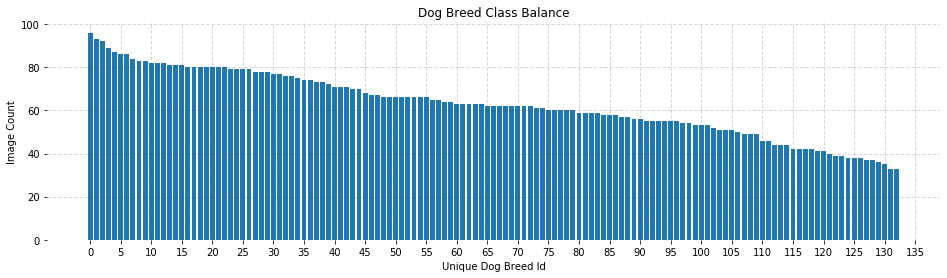

In [11]:
display_dog_class_balance(AIND_DOG_DIR)

As possible to observe there is a slight inbalance in class distribution.

Preview of few images:

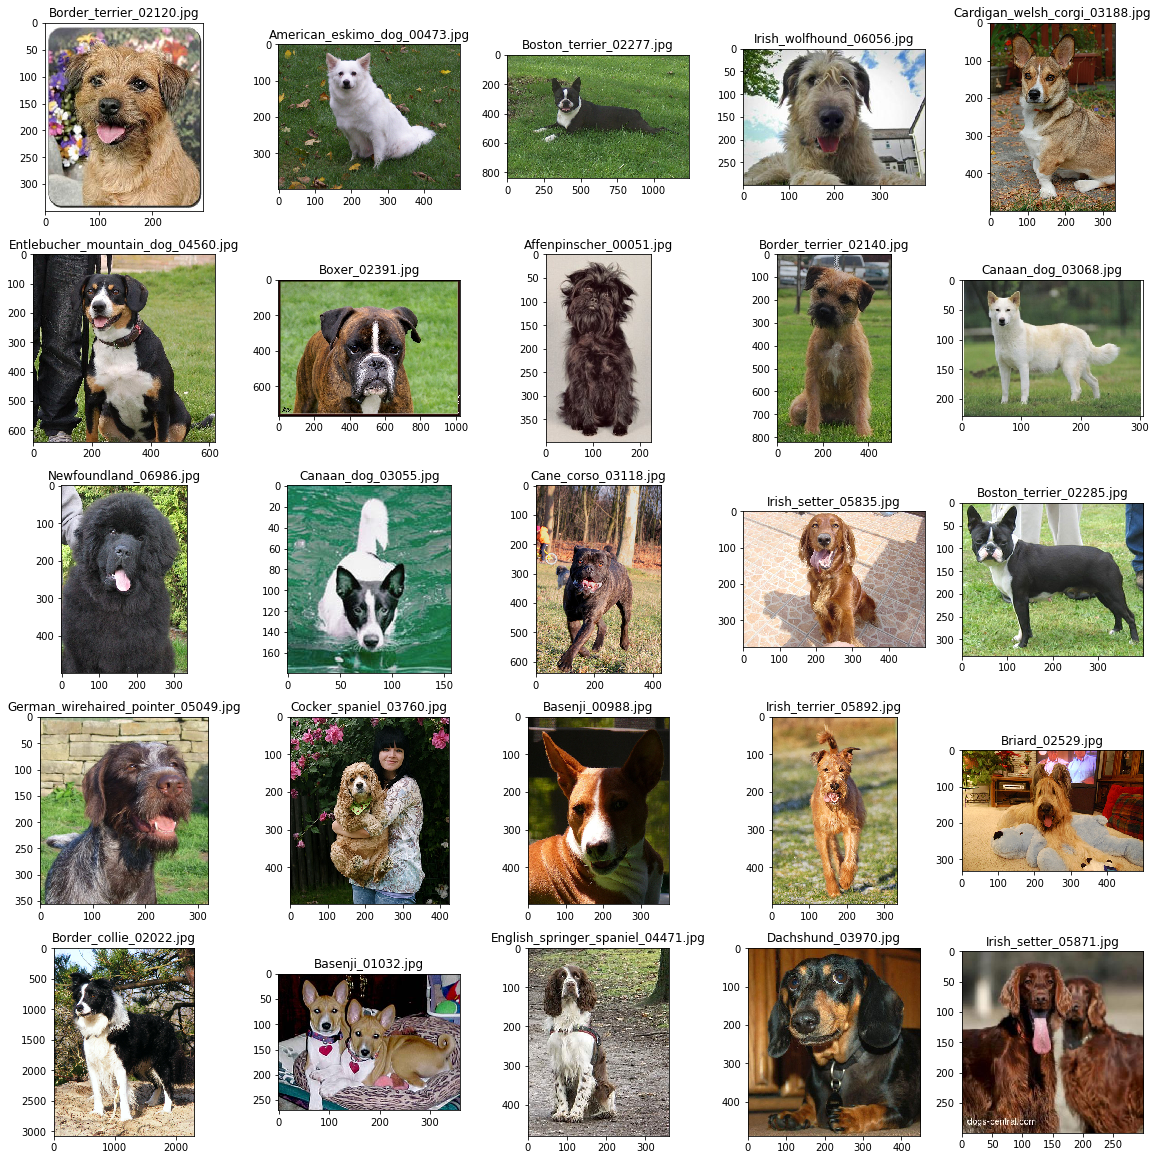

In [12]:
display_random_image_grid(dog_train[0])

Spotted potential issues:

1. Many dogs on the same image.
    
       This is not big problem but there are dogs of similar breeds - for example German Pinscher and Doberman are similar. Depending on how image is taken and what dogs do, models can get confused. Because of that ideal case is when there is a single dog on image and looking upfront.
    
    
2. Dogs of more than one breed on the same image.

       This is huge problem. For example image `Irish_wolfhound_06083.jpg` shows dog of Irish Wolfhound breed that is playing with two other smaller dogs of the same breed. Model won't have idea which dog is the most important one. It might lead to bias where model is mixing predictions for dogs of the same breed and problems with model generalization.
    
    
3. People together with dogs.

       System should be able to differentiate between dogs and humans. If there is a dog and human on the same image then there might be problem with handling further logic. There is no way to predict dog-breed for both separately.

#### Loading: aind_human_images

There are no labels provided for human images. 

In [13]:
human_train, human_val, human_test = load_aind_human_data(AIND_HUMAN_URL, AIND_HUMAN_DIR)

Path 'data/aind_human_images' found, loading cached data.


In [14]:
print("Image number in datasets:")
for label, data in zip(["train", "val", "test"], [human_train, human_val, human_test]):
    print(" - {}: {}".format(label, data.shape[0]))

Image number in datasets:
 - train: 10586
 - val: 1323
 - test: 1324


Preview of few images:

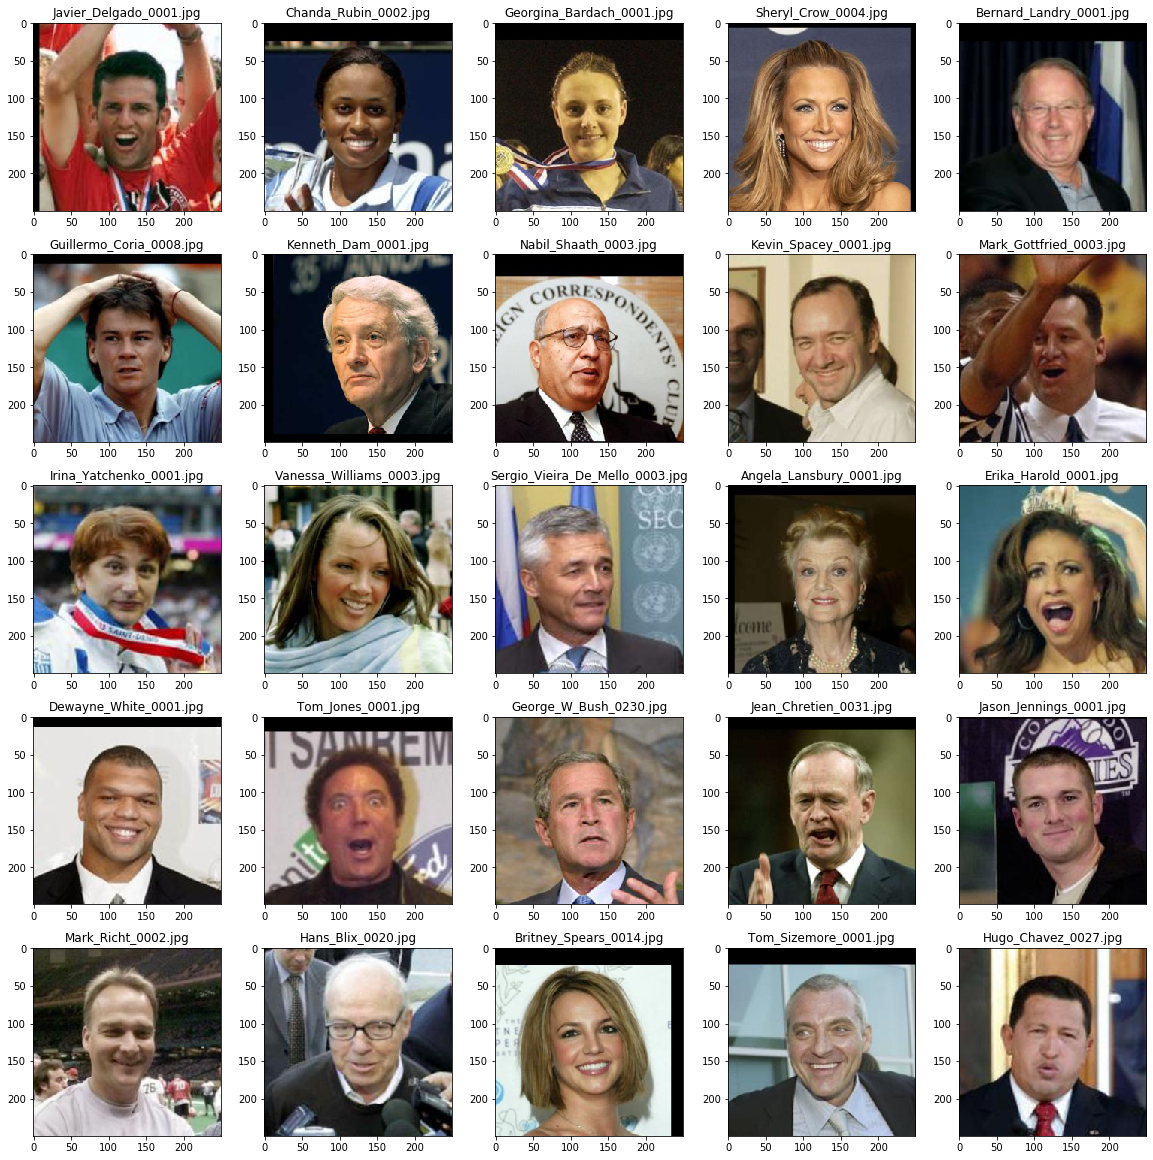

In [15]:
display_random_image_grid(human_train)

Human images won't be used much in this project. Just for face detection. For sure when detecting specific humans, there might be issue because there are sometimes many people on the same image.

#### Loading : test_images

In [16]:
test_data = load_test_images(TEST_IMAGES_URL, TEST_IMAGES_DIR)

Path 'data/test_images' found, loading cached data.


In [17]:
for img_path in os.listdir(TEST_IMAGES_DIR):
    print(img_path)

nondog9.jpg
nondog3.jpg
dog1_dalmatian.jpg
dog2_pug.jpg
nondog2.jpg
nondog10.png
nondog5.jpeg
nondog4.jpeg
nondog6.png
person2.jpg
person1.jpg
person4.png
nondog8.jpg
dog3_doberman.jpg
person3.png
person5.jpg
nondog7.jpeg
dog5_siberian_husky.jpg
dog4_golden_retriever.jpg
nondog1.jpg


Preview of few images:

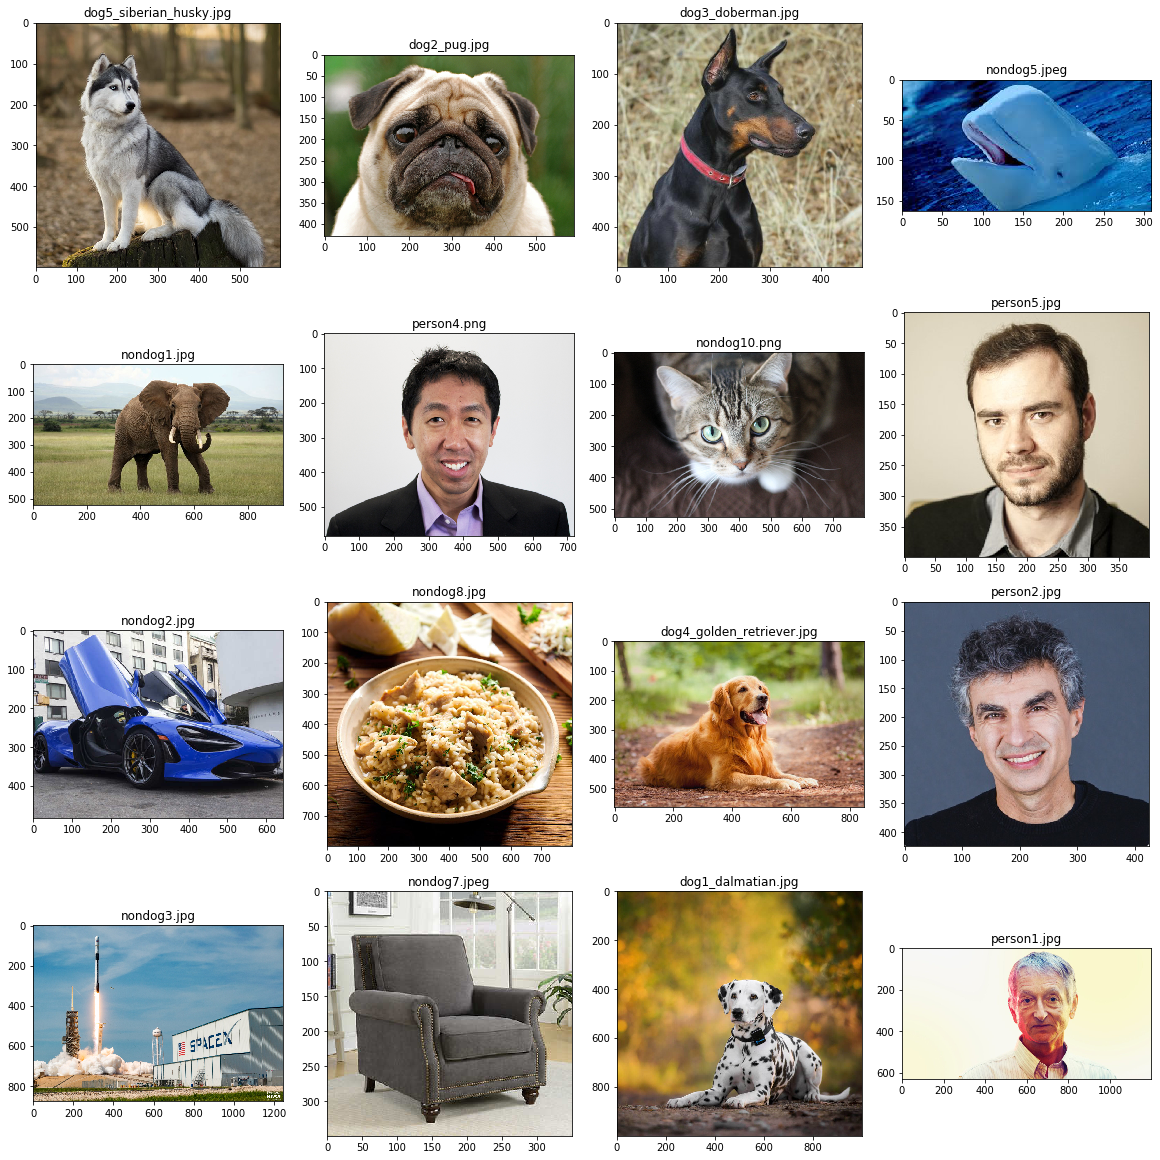

In [18]:
display_random_image_grid(test_data, rows=4, cols=4)

Randomly picked image for web might be troublesome for the system when it comes to dog breed prediction. Picked image of Pug and Doberman doesnt show whole dog body. It might get mistaken for smiliar breeds.

## Finding human detector

#### OpenCV Haar Cascade based human predictor

OpenCV provides already pretrained detectors of shapes within an image. Those detectors are named Haar Cascades. Few of them supports detecting human faces within an image. They slide a scanning window over the image in order to find shape which is known to them. It could be used instead of Neural Network, as when human face is found on image then model could return `human` label or `none` label otherwise.

In [19]:
def build_haar_cascade_human_predictor(cascade_path):
    """Builds a Predictor class encapsulating haar cascade.
    
    Parameters:
    -----------
    cascade_path: str
        Path to haar cascade .xml file.
        
    Returns:
    -----------
    predictor: Predictor
        Class capable of making prediction with model and it preprocessing functions
        stored inside kwargs.

    """
    def _human_predictor(img_path, **kwargs):
        """Function for detecting humans with haar cascade.
        
        Parameters:
        -----------
        img_path: str
            Path to image file.
        kwargs: **kwargs
            Container with model and related functions.
            
        Returns:
        -----------
        result: int
            Returns integer representing binary class (1: human, 0: no human).
        """
        clf = kwargs.get("cascade")
        to_tensor_function = kwargs.get("to_tensor")
       
        img = to_tensor_function(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        result = clf.detectMultiScale(img_gray)
        return int(len(result) > 0)
        
    kwargs = {
        "cascade": cv2.CascadeClassifier(cascade_path),
        "to_tensor": cv2.imread
    }
    
    label = cascade_path.split(os.path.sep)[-1][:-4]
    predictor = Predictor(_human_predictor, label, **kwargs)
   
    return predictor

- Building predictors

In [20]:
for cascade_name, cascade_url in OPENCV_HAAR_CASCADES.items():
    cascade_filepath = os.path.join(OPENCV_HAAR_CASCADES_DIR, cascade_name)
    download_haar_cascade(cascade_url, cascade_filepath)

    predictor = build_haar_cascade_human_predictor(cascade_filepath)
    
    predictors[PREDICTOR_TYPE_HUMAN][predictor.label] = predictor

File 'haarcascades/haarcascade_frontalcatface.xml' already exists.
File 'haarcascades/haarcascade_frontalcatface_extended.xml' already exists.
File 'haarcascades/haarcascade_frontalface_alt.xml' already exists.
File 'haarcascades/haarcascade_frontalface_alt2.xml' already exists.
File 'haarcascades/haarcascade_frontalface_alt_tree.xml' already exists.
File 'haarcascades/haarcascade_frontalface_default.xml' already exists.


#### Compare human predictors

In [21]:
test_binary_predictors(
    predictors[PREDICTOR_TYPE_HUMAN], human_train[:500], dog_train[0][:500]
)

                   haarcascade_frontalface_default: 100%|██████████| 500/500 [00:22<00:00, 14.36it/s]


accuracy  f1_score  true_positive  \
haarcascade_frontalcatface              0.503  0.234206             76   
haarcascade_frontalcatface_extended     0.481  0.142149             43   
haarcascade_frontalface_alt             0.935  0.938505            496   
haarcascade_frontalface_alt2            0.883  0.894118            494   
haarcascade_frontalface_alt_tree        0.741  0.657860            249   
haarcascade_frontalface_default         0.725  0.783975            499   

                                     true_negative  false_positive  \
haarcascade_frontalcatface                     424             427   
haarcascade_frontalcatface_extended            457             438   
haarcascade_frontalface_alt                      4             439   
haarcascade_frontalface_alt2                     6             389   
haarcascade_frontalface_alt_tree               251             492   
haarcascade_frontalface_default                  1             226   

                                     false_negative  
haarcascade_frontalcatface                       73  
haarcascade_frontalcatface_extended              62  
haarcascade_frontalface_alt                      61  
haarcascade_frontalface_alt2                    111  
haarcascade_frontalface_alt_tree                  8  
haarcascade_frontalface_default                 274

## Finding dog predictor

#### ResNet50 based dog predictor

ResNet50 is large neural network which is currently pre-trained and capable of categorizing dog breeds.

Because format of the model is already set, function `preprocess_input` needs to be used on image:

```
First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  
```

Then model returns softmax probability on each of its outputs. Number of outputs equals to number of classes (1000) which it was taught. Class details can be found here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a. 

It is possible to observe that dog indices are located between values 151 and 268.

In [22]:
def build_resnet50_dog_predictor():
    """Builds a Predictor class encapsulating pre-trained ResNet50 model.
    
    Parameters:
    -----------
    None
        
    Returns:
    -----------
    predictor: Predictor
        Class capable of making prediction with model and it preprocessing functions
        stored inside kwargs.

    """
    
    def _dog_predictor(img_path, **kwargs):
        """Function for detecting dogs with ResNet 50 model.
        
        Parameters:
        -----------
        img_path: str
            Path to image file.
        kwargs: **kwargs
            Container with model and related functions.
            
        Returns:
        -----------
        result: int
            Returns integer representing binary class (1: dog, 0: no dog).
        """
        clf = kwargs.get("model")
        to_tensor_function = kwargs.get("to_tensor")
        preprocess_input_function = kwargs.get("preprocess_input")
         
        img = to_tensor_function(img_path)
        img = preprocess_input_function(img)
        
        result = np.argmax(clf.predict(img))
        
        return int((result <= 268) and (result >= 151)) 
        
    kwargs = {
        "model": ResNet50(weights="imagenet"),   
        "to_tensor": path_to_tensor,
        "preprocess_input": resnet50_preprocess_input
    }
    
    label = "resnet50"
    predictor = Predictor(_dog_predictor, label, **kwargs)
   
    return predictor

- Build predictor

In [23]:
predictor = build_resnet50_dog_predictor()
predictors[PREDICTOR_TYPE_DOG][predictor.label] = predictor

#### Compare dog predictors

In [24]:
test_binary_predictors(
    predictors[PREDICTOR_TYPE_DOG], dog_train[0][:500], human_train[:500]
)

                                          resnet50: 100%|██████████| 500/500 [00:06<00:00, 75.77it/s]


accuracy  f1_score  true_positive  true_negative  false_positive  \
resnet50     0.988  0.987952            492              8             496   

          false_negative  
resnet50               4

## Finding dog-breed predictor

#### Dog-breed predictor from scratch
Using available data in order to build dog-breed predictor.

In this section, following ideas will be tried:

1. Building CNN from sctrach

    Training model from scratch just on available dog-breed images. It is expected to be a baseline for this problem. It is a neural network of convolutional type. It scans image with kernels, where each kernel cell has weight attached to it that is trainable. Thanks to that neural network is capable of training it's own filters and decide what is the best way to look at the image. Convolutional layers are stacked in pairs, as it allows neural network to perform feature extraction twice. First convolution picks pixels which are activating output the most and second one selects the best of the best. Between convolution pairs maxpooling technique is used with usage of kernel size (2,2). It scans convolution results with small matrix of size 2x2 and picks pixel with the highest value. Picked architecture is a trade of between efficiency and training time. To achieve that dense layers are ommited as convolutional layers requires less features to train.
    
    
2. Finetuning large neural networks of known architectures

    There are already pre-trained large neural networks such as VGG16, VGG19, ResNet50, Exception, InceptionV3 and much more. As all of those architectures are meant to work with images they contain already weight which know how to look at images. What is done here is transfer learning by finetuning. Whole convolutional part, containing image knowledge, is frozen and weight are left unchanged. Input image goes through the frozen part and gives an output that becomes an input to attached trainable layers and different outputs. That way "frozen knowledge" within already pre-trained network is used to discriminate between image and trainable parts are responsible only for making conclusions about data.

In [25]:
def build_custom_cnn_dogbreed_predictor(dog_train, dog_val):
    """Builds a Predictor class encapsulating CNN model.
    
    Parameters:
    -----------
    dog_train: tuple
        Container with train images filepaths and train targets.
    dog_val: tuple
        Container with validation images filepaths and validation targets.
        
    Returns:
    -----------
    predictor: Predictor
        Class capable of making prediction with model and it preprocessing functions
        stored inside kwargs.
    """  
    def _dogbreed_predictor(img_path, **kwargs):
        """Function for detecting dog-breed with CNN model.
        
        Parameters:
        -----------
        img_path: str
            Path to image file.
        kwargs: **kwargs
            Container with model and related functions.
            
        Returns:
        -----------
        result: int
            Returns integer representing class.
        """
        clf = kwargs.get("model")
        to_tensor_function = kwargs.get("to_tensor")
        preprocess_input_fucntion = kwargs.get("preprocess_input")
        
        img = to_tensor_function(img_path)
        img = preprocess_input_fucntion(img)
        
        result = np.argmax(clf.predict(img))
        
        return result
    
    def _preprocess_input(img):
        """Function for scaling pixel values to <0.0, 1.0> range. 
        
        Parameters:
        -----------
        img: numpy.ndarray
            Array with RGB images, with pixel values in range <0.0, 255.0>.
            
        Returns:
        -----------
        img: numpy.ndarray
            Scaled image.
        """
        return img.astype("float32") / 255.0
    
    def _train_model(dog_train_i, dog_train_t, dog_val_i, dog_val_t):
        """Function for building, compiling and training custom CNN model.
        It saves best model to SAVED_MODELS_DIR.
        
        Parameters:
        -----------
        dog_train_i: numpy.ndarray
            Array with loaded train images into numpy.ndarray format.
        dog_train_t: numpy.ndarray
            Array with one-hot encoded train targets.
        dog_val_i: numpy.ndarray
            Array with loaded validation images into numpy.ndarray format.
        dog_val_t: numpy.ndarray
            Array with one-hot encoded validation targets.
            
        Returns:
        -----------
        model: Sequential
            Trained model with loaded weights from best epoch.
        history: dict
            Dictionary containing data about model training process.
        """
        model = Sequential()
        model.add(Dense(input_shape=(224, 224, 3), units=16))

        model.add(Conv2D(filters=16, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(Conv2D(filters=16, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(MaxPool2D(pool_size=(2), strides=(2), padding="valid"))
        model.add(Dropout(0.2))

        model.add(Conv2D(filters=32, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(Conv2D(filters=32, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(MaxPool2D(pool_size=(2), strides=(2), padding="valid"))
        model.add(Dropout(0.2))
        
        model.add(Conv2D(filters=32, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(Conv2D(filters=32, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(MaxPool2D(pool_size=(2), strides=(2), padding="valid"))
        model.add(Dropout(0.2))

        model.add(Conv2D(filters=64, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(Conv2D(filters=64, kernel_size=2, strides=1, 
                         padding="valid", activation="relu"))
        model.add(MaxPool2D(pool_size=(2), strides=(2), padding="same"))
        
        model.add(GlobalAveragePooling2D())
        model.add(Dense(units=AIND_DOG_CLASSES_NUM, activation="softmax"))

        model.summary()
        
        model.compile(
            optimizer=RMSprop(0.002), loss="categorical_crossentropy", metrics=["accuracy"]
        )

        best_model_filepath = os.path.join(SAVED_MODELS_DIR, "custom_cnn_dogbreed.h5")
        checkpointer = ModelCheckpoint(
            filepath=best_model_filepath, verbose=1, save_best_only=True, 
            save_weights_only=False
        )

        history = model.fit(
            dog_train_i, dog_train_t, 
            validation_data=(dog_val_i, dog_val_t),
            epochs=200, batch_size=64, callbacks=[checkpointer], verbose=1
        )

        model = load_model(best_model_filepath, compile=False)
        
        return history, model
        
    dog_train_i, dog_train_t = dog_train
    dog_val_i, dog_val_t = dog_val
    
    print("Converting dog-breed train images to tensor...")
    time.sleep(0.25)
    dog_train_i = paths_to_tensor(dog_train_i)
    
    print("Converting dog-breed validation images to tensor...")
    time.sleep(0.25)
    dog_val_i = paths_to_tensor(dog_val_i)
    
    print("Normalizing dog-breed train data...")
    dog_train_i = _preprocess_input(dog_train_i)
    
    print("Normalizing dog-breed val data...")
    dog_val_i = _preprocess_input(dog_val_i)
    
    print("Training model...")
    history, model = _train_model(dog_train_i, dog_train_t, dog_val_i, dog_val_t)
    label = "custom_cnn_dogbreed"
    display_training_history(history, label)

    print("Constructing predictor...")
    kwargs = {
        "model": model,
        "to_tensor": path_to_tensor,
        "preprocess_input": _preprocess_input
    }
    
    predictor = Predictor(_dogbreed_predictor, label, **kwargs)
    
    return predictor

- Build predictor

Converting dog-breed train images to tensor...


100%|██████████| 6680/6680 [00:46<00:00, 142.39it/s]


Converting dog-breed validation images to tensor...


100%|██████████| 835/835 [00:08<00:00, 99.64it/s] 


Normalizing dog-breed train data...
Normalizing dog-breed val data...
Training model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 224, 224, 16)      64        
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 223, 223, 16)      1040      
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 222, 222, 16)      1040      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 110, 110, 32)      2080      
______________________________________________________

6680/6680 [==============================] - 16s 2ms/step - loss: 2.9662 - acc: 0.2675 - val_loss: 3.8136 - val_acc: 0.1617

Epoch 00065: val_loss did not improve from 3.71602
Epoch 66/200
6680/6680 [==============================] - 16s 2ms/step - loss: 2.9337 - acc: 0.2713 - val_loss: 3.9185 - val_acc: 0.1293

Epoch 00066: val_loss did not improve from 3.71602
Epoch 67/200
6680/6680 [==============================] - 16s 2ms/step - loss: 2.9168 - acc: 0.2814 - val_loss: 3.9887 - val_acc: 0.1246

Epoch 00067: val_loss did not improve from 3.71602
Epoch 68/200
6680/6680 [==============================] - 16s 2ms/step - loss: 2.8888 - acc: 0.2864 - val_loss: 3.8281 - val_acc: 0.1317

Epoch 00068: val_loss did not improve from 3.71602
Epoch 69/200
6680/6680 [==============================] - 16s 2ms/step - loss: 2.8604 - acc: 0.2927 - val_loss: 3.5944 - val_acc: 0.1665

Epoch 00069: val_loss improved from 3.71602 to 3.59438, saving model to saved_models/custom_cnn_dogbreed.h5
Epoch 70/20

6680/6680 [==============================] - 16s 2ms/step - loss: 1.8875 - acc: 0.4957 - val_loss: 4.1125 - val_acc: 0.2228

Epoch 00150: val_loss did not improve from 3.46259
Epoch 151/200
6680/6680 [==============================] - 16s 2ms/step - loss: 1.8856 - acc: 0.4904 - val_loss: 4.0253 - val_acc: 0.2359

Epoch 00151: val_loss did not improve from 3.46259
Epoch 152/200
6680/6680 [==============================] - 16s 2ms/step - loss: 1.8550 - acc: 0.4943 - val_loss: 3.7734 - val_acc: 0.2671

Epoch 00152: val_loss did not improve from 3.46259
Epoch 153/200
6680/6680 [==============================] - 16s 2ms/step - loss: 1.8202 - acc: 0.5100 - val_loss: 3.8307 - val_acc: 0.2587

Epoch 00153: val_loss did not improve from 3.46259
Epoch 154/200
6680/6680 [==============================] - 16s 2ms/step - loss: 1.8311 - acc: 0.5004 - val_loss: 3.6826 - val_acc: 0.2228

Epoch 00154: val_loss did not improve from 3.46259
Epoch 155/200
6680/6680 [==============================] - 16s 2

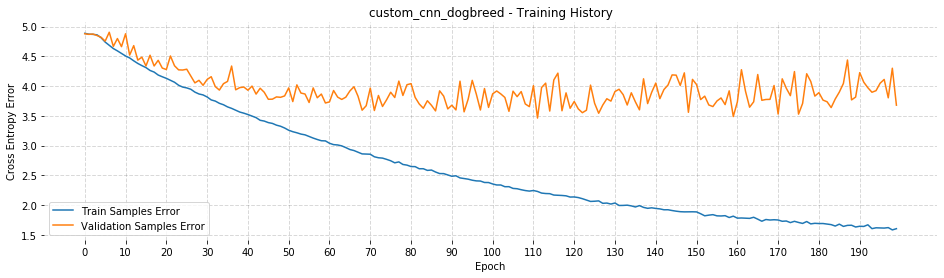

Constructing predictor...


In [36]:
predictor = build_custom_cnn_dogbreed_predictor(dog_train, dog_val)
predictors[PREDICTOR_TYPE_DOG_BREED][predictor.label] = predictor

#### Transfer-learning based dog-breed predictor
Using `VGG16`, `VGG19`, `InceptionV3` architectures.

In [27]:
def build_finetuned_dogbreed_predictor(dog_train, dog_val, model_class,
                                       label, preprocess_input_func):
    """Builds a Predictor class encapsulating finetuned model.
    
    Parameters:
    -----------
    dog_train: tuple
        Container with train images filepaths and train targets.
    dog_val: tuple
        Container with validation images filepaths and validation targets.
    model_class: function
        Keras function for loading transfer learned model like VGG19, ResNet50 etc.    
    label: str
        Model label for ModelCheckpoint output filename and Predictor identification.
    preprocess_input_func: function
        Function for preprocessing inputs for choosen network architecture. 
        
    Returns:
    -----------
    predictor: Predictor
        Class capable of making prediction with model and it preprocessing functions
        stored inside kwargs.
    """  
    def _dogbreed_predictor(img_path, **kwargs):
        clf = kwargs.get("model")
        to_tensor_function = kwargs.get("to_tensor")
        preprocess_input_fucntion = kwargs.get("preprocess_input")
        
        img = to_tensor_function(img_path)
        img = preprocess_input_fucntion(img)
        
        result = np.argmax(clf.predict(img))
        
        return result
    
    def _train_model(model_class, label, dog_train_i, dog_train_t, dog_val_i, dog_val_t):
        """Function for performing trainsfer_learning on specified architecture.
        Model is loaded without top dense layers and with 'imagenet' weights. All
        layers are frozen and trainable GlobalAveragePooling2D + output dense 
        layers are added. It saves best model to SAVED_MODELS_DIR.

        Parameters:
        -----------
        model_class: function
            Keras function for loading transfer learned model like VGG19, ResNet50 etc.
        label: str
            Model label for ModelCheckpoint output filename.
        dog_train_i: numpy.ndarray
            Array with loaded train images into numpy.ndarray format.
        dog_train_t: numpy.ndarray
            Array with one-hot encoded train targets.
        dog_val_i: numpy.ndarray
            Array with loaded validation images into numpy.ndarray format.
        dog_val_t: numpy.ndarray
            Array with one-hot encoded validation targets.

        Returns:
        -----------
        model: Sequential
            Trained model with loaded weights from best epoch.
        history: dict
            Dictionary containing data about model training process.
        """
        model = model_class(weights="imagenet", include_top=False)
        
        last_layer_name = model.layers[-1].name
        
        last_layer = model.get_layer(last_layer_name).output
        x = GlobalAveragePooling2D(name="g_avg_pooling_2d")(last_layer)
        out = Dense(AIND_DOG_CLASSES_NUM, activation="softmax", name="custom_fc1")(x)

        custom_model = Model(model.input, out)
        
        for layer in custom_model.layers:
            if layer.name != "g_avg_pooling_2d":
                layer.trainable = False
            else:
                break

        custom_model.summary()
        
        custom_model.compile(
            optimizer=RMSprop(0.001), loss="categorical_crossentropy", metrics=["accuracy"]
        )

        best_model_filepath = os.path.join(SAVED_MODELS_DIR, "{}_dogbreed.h5".format(label))
        checkpointer = ModelCheckpoint(
            filepath=best_model_filepath, verbose=1, save_best_only=True, 
            save_weights_only=False
        )


        history = custom_model.fit(
            dog_train_i, dog_train_t, 
            validation_data=(dog_val_i, dog_val_t),
            epochs=50, batch_size=32, callbacks=[checkpointer], verbose=1
        )

        custom_model = load_model(best_model_filepath, compile=False)
        
        return history, custom_model
        
    dog_train_i, dog_train_t = dog_train
    dog_val_i, dog_val_t = dog_val
    
    print("Converting dog-breed train images to tensor...")
    time.sleep(0.25)
    dog_train_i = paths_to_tensor(dog_train_i)
    
    print("Converting dog-breed validation images to tensor...")
    time.sleep(0.25)
    dog_val_i = paths_to_tensor(dog_val_i)
    
    print("Normalizing dog-breed train data...")
    dog_train_i = preprocess_input_func(dog_train_i)
    
    print("Normalizing dog-breed val data...")
    dog_val_i = preprocess_input_func(dog_val_i)
    
    print("Training model...")
    history, model = _train_model(
        model_class, label, dog_train_i, dog_train_t, dog_val_i, dog_val_t)
    display_training_history(history, label)

    print("Constructing predictor...")    
    kwargs = {
        "model": model,
        "to_tensor": path_to_tensor,
        "preprocess_input": preprocess_input_func
    }
    
    predictor = Predictor(_dogbreed_predictor, label, **kwargs)
    
    return predictor

- Build predictors

Converting dog-breed train images to tensor...


100%|██████████| 6680/6680 [01:37<00:00, 68.24it/s]


Converting dog-breed validation images to tensor...


100%|██████████| 835/835 [00:09<00:00, 84.87it/s] 


Normalizing dog-breed train data...
Normalizing dog-breed val data...
Training model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________

6680/6680 [==============================] - 32s 5ms/step - loss: 5.3489 - acc: 0.6641 - val_loss: 6.4643 - val_acc: 0.5102

Epoch 00022: val_loss did not improve from 6.43655
Epoch 23/50
6680/6680 [==============================] - 32s 5ms/step - loss: 5.3152 - acc: 0.6644 - val_loss: 6.4125 - val_acc: 0.5138

Epoch 00023: val_loss improved from 6.43655 to 6.41251, saving model to saved_models/vgg16_dogbreed.h5
Epoch 24/50
6680/6680 [==============================] - 32s 5ms/step - loss: 5.2896 - acc: 0.6680 - val_loss: 6.3933 - val_acc: 0.5066

Epoch 00024: val_loss improved from 6.41251 to 6.39332, saving model to saved_models/vgg16_dogbreed.h5
Epoch 25/50
6680/6680 [==============================] - 32s 5ms/step - loss: 5.2202 - acc: 0.6669 - val_loss: 6.5078 - val_acc: 0.4982

Epoch 00025: val_loss did not improve from 6.39332
Epoch 26/50
6680/6680 [==============================] - 31s 5ms/step - loss: 4.9943 - acc: 0.6711 - val_loss: 6.2693 - val_acc: 0.5138

Epoch 00026: val_lo

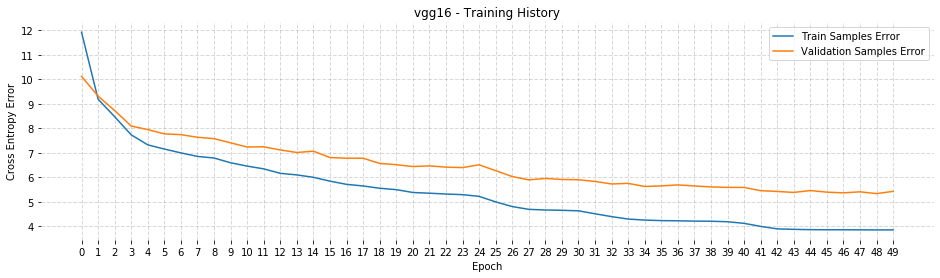

Constructing predictor...


In [28]:
predictor = build_finetuned_dogbreed_predictor(
    dog_train, dog_val, VGG16, "vgg16", vgg16_preprocess_input)
predictors[PREDICTOR_TYPE_DOG_BREED][predictor.label] = predictor

Converting dog-breed train images to tensor...


100%|██████████| 6680/6680 [00:34<00:00, 131.91it/s]


Converting dog-breed validation images to tensor...


100%|██████████| 835/835 [00:06<00:00, 129.08it/s]


Normalizing dog-breed train data...
Normalizing dog-breed val data...
Training model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________


Epoch 00020: val_loss did not improve from 6.69623
Epoch 21/50
6680/6680 [==============================] - 36s 5ms/step - loss: 5.7944 - acc: 0.6329 - val_loss: 6.5560 - val_acc: 0.5174

Epoch 00021: val_loss improved from 6.69623 to 6.55597, saving model to saved_models/vgg19_dogbreed.h5
Epoch 22/50
6680/6680 [==============================] - 36s 5ms/step - loss: 5.7631 - acc: 0.6343 - val_loss: 6.5717 - val_acc: 0.5066

Epoch 00022: val_loss did not improve from 6.55597
Epoch 23/50
6680/6680 [==============================] - 37s 5ms/step - loss: 5.7068 - acc: 0.6392 - val_loss: 6.5731 - val_acc: 0.5150

Epoch 00023: val_loss did not improve from 6.55597
Epoch 24/50
6680/6680 [==============================] - 36s 5ms/step - loss: 5.6502 - acc: 0.6427 - val_loss: 6.4508 - val_acc: 0.5150

Epoch 00024: val_loss improved from 6.55597 to 6.45079, saving model to saved_models/vgg19_dogbreed.h5
Epoch 25/50
6680/6680 [==============================] - 36s 5ms/step - loss: 5.5065 - acc: 

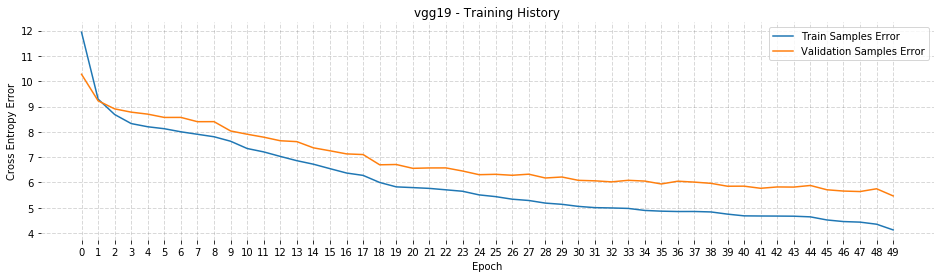

Constructing predictor...


In [29]:
predictor = build_finetuned_dogbreed_predictor(
    dog_train, dog_val, VGG19, "vgg19", vgg19_preprocess_input)
predictors[PREDICTOR_TYPE_DOG_BREED][predictor.label] = predictor

Converting dog-breed train images to tensor...


100%|██████████| 6680/6680 [00:34<00:00, 132.22it/s]


Converting dog-breed validation images to tensor...


100%|██████████| 835/835 [00:03<00:00, 218.10it/s]


Normalizing dog-breed train data...
Normalizing dog-breed val data...
Training model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
_____________________

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 21s 3ms/step - loss: 2.7427 - acc: 0.4075 - val_loss: 1.0279 - val_acc: 0.7234

Epoch 00001: val_loss improved from inf to 1.02794, saving model to saved_models/inceptionV3_dogbreed.h5
Epoch 2/50
6680/6680 [==============================] - 17s 3ms/step - loss: 1.3345 - acc: 0.6593 - val_loss: 0.9764 - val_acc: 0.7689

Epoch 00002: val_loss improved from 1.02794 to 0.97636, saving model to saved_models/inceptionV3_dogbreed.h5
Epoch 3/50
6680/6680 [==============================] - 17s 3ms/step - loss: 1.0037 - acc: 0.7250 - val_loss: 0.9575 - val_acc: 0.7892

Epoch 00003: val_loss improved from 0.97636 to 0.95753, saving model to saved_models/inceptionV3_dogbreed.h5
Epoch 4/50
6680/6680 [==============================] - 17s 3ms/step - loss: 0.7989 - acc: 0.7738 - val_loss: 1.0579 - val_acc: 0.7796

Epoch 00004: val_loss did not improve from 0.95753
Epoch 5/50
6680/6680 [=============

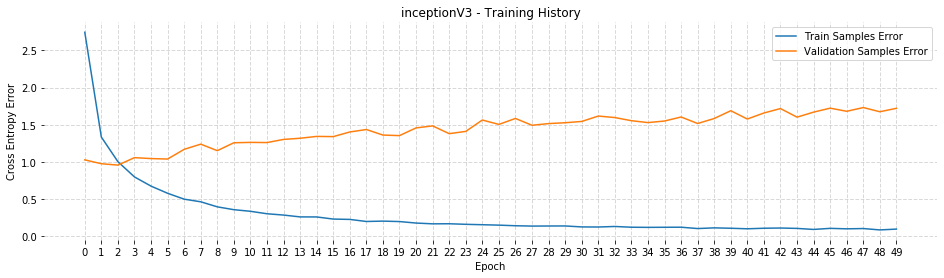

Constructing predictor...


In [30]:
predictor = build_finetuned_dogbreed_predictor(
    dog_train, dog_val, InceptionV3, "inceptionV3", inceptionv3_preprocess_input)
predictors[PREDICTOR_TYPE_DOG_BREED][predictor.label] = predictor

#### Compare dog-breed predictors

In [37]:
dog_test_input, dog_test_labels = dog_test

test_multiclass_predictors(
    predictors[PREDICTOR_TYPE_DOG_BREED], dog_test_input, dog_test_labels
)

                                       inceptionV3: 100%|██████████| 836/836 [00:22<00:00, 37.61it/s]


accuracy  f1_score
custom_cnn_dogbreed  0.223684  0.238902
vgg16                0.574163  0.637266
vgg19                0.566986  0.628906
inceptionV3          0.775120  0.785253

## System Assembly

The best candidates based on `f1_score` are:
- human predictor: `haarcascade_frontalface_alt`
- dog predictor: `resnet50`
- dog-breed predictor: `inceptionV3`

Preparing class that is capable of recreating system outside of notebook.

In [32]:
class HumanDogBreedPredictor:
    """Class which combines 'haarcascade_frontalface_alt', 'ResNet50' and finetuned 
    'InceptionV3' models into system that detects humans and dogs and returns dog breed
    for the image."""
    
    def __init__(self, human_predictor_filepath, dog_breed_predictor_filepath, dog_names):
        """Class constructor.

        Parameters:
        -----------
        human_predictor_filepath: str
            Path to .xml file of 'haarcascade_frontalface_alt' cascade.
        dog_breed_predictor_filepath: str
            Path to .h5 keras model file.
        dog_names: list
            List containing dog breed names in the same order as softmax output of
            trained dog breed precition network.
            
        Returns:
        -----------
        None
        """
        self.human_predictor = self._init_human_predictor(human_predictor_filepath)
        print("Succesfully loaded human predictor!")
        
        self.dog_predictor = self._init_dog_predictor()
        print("Succesfully loaded dog predictor!")
        
        self.dogbreed_predictor = self._init_dog_breed_predictor(dog_breed_predictor_filepath)
        print("Succesfully loaded dog_breed predictor!")
        
        self.dog_names = dog_names
        
    def _init_human_predictor(self, path):
        """Method which loads human predictor.

        Parameters:
        -----------
        path: str
            Path to .xml file of 'haarcascade_frontalface_alt' cascade.
            
        Returns:
        -----------
        human_predictor: cv2.CascadeClassifier
            Loaded cascade file wrapped in OpenCV class.
        """
        human_predictor = cv2.CascadeClassifier(path)
        return human_predictor
    
    def _init_dog_predictor(self):
        """Method which loads dog predictor.

        Parameters:
        -----------
        None
            
        Returns:
        -----------
        dog_predictor: Sequential
            Keras ResNet50 model.
        """
        dog_predictor = ResNet50(weights="imagenet")
        return dog_predictor
    
    def _init_dog_breed_predictor(self, path):
        """Method which loads dog breed predictor.

        Parameters:
        -----------
        path: str
            Path to .h5 keras model file.
            
        Returns:
        -----------
        dog_breed_predictor: Sequential
            Finetuned InceptionV3 Keras model.
        """
        dog_breed_predictor = load_model(path, compile=False)
        return dog_breed_predictor
       
    @staticmethod
    def _path_to_tensor(img_path, img_size=(224, 224)):
        """Method takes image from specific filepath, resizes it and saves as numpy.ndarray.

        Parameters:
        -----------
        img_path: str
            Filepath to image file.
        img_size: tuple
            Tuple to which loaded image will be resized.

        Returns:
        -----------
        img: numpy.ndarray
            Returns loaded and resized image.
        """
        img = image.load_img(img_path, target_size=img_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        return img
    
    def _human_prediction(self, img_path):
        """For given image path returns flag whether it contains human or not.

        Parameters:
        -----------
        img_path: str
            Filepath to image file.

        Returns:
        -----------
        result: int
            Value 1 if image contains human, 0 otherwise.
        """
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result = int(len(self.human_predictor.detectMultiScale(img_gray)) > 0)
        return result
    
    def _dog_prediction(self, img_path):
        """For given image path returns flag whether it contains dog or not.

        Parameters:
        -----------
        img_path: str
            Filepath to image file.

        Returns:
        -----------
        result: int
            Value 1 if image contains human, 0 otherwise.
        """
        img = self._path_to_tensor(img_path)
        img = resnet50_preprocess_input(img)
        result = np.argmax(self.dog_predictor.predict(img))
        result = int((result <= 268) and (result >= 151)) 
        return result
    
    def _dogbreed_prediction(self, img_path):
        """For given image path returns id of dog breed class.

        Parameters:
        -----------
        img_path: str
            Filepath to image file.

        Returns:
        -----------
        result: int
            Id of dog breed class.
        """
        img = self._path_to_tensor(img_path)
        img = inceptionv3_preprocess_input(img)
        result = np.argmax(self.dogbreed_predictor.predict(img))
        return result
        
    def predict(self, img_path, plot=False, verbose=False):
        """Method which for given image path loads image, makes prediction
        with each prediction and based on the results returns communicate to user.
        
        Parameters:
        -----------
        img_path: str
            Filepath to image file.
        plot: bool
            If set to true, sent image will be also displayed.
        verbose: bool
            If set to true, function will display messages to user.

        Returns:
        -----------
        is_human: int
            Information whether image contains human.
        is_dog: int
            Information whether image contains dog.
        dog_breed: str
            Name of the dog breed.
        """
        print("Making prediction for: {}".format(img_path))
        
        is_human = self._human_prediction(img_path)
        is_dog = self._dog_prediction(img_path)
        dog_breed =  self.dog_names[self._dogbreed_prediction(img_path)]
        
        if plot:
            img = cv2.imread(img_path)
            cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(cv_rgb)
            plt.show()
        
        if verbose:
            if is_dog and is_human:
                print("\t- System got confused... it seems that it's a "
                      + "dog and human at the same time. Scary!")
            elif is_dog:
                print("\t- This is dog of breed: {}".format(dog_breed))
            elif is_human:
                print("\t- This is human that looks like dog of breed: {}".format(dog_breed))
            else:
                print("\t- This is neither dog or human.")
            
        return is_human, is_dog, dog_breed

In [33]:
human_predictor_dir = os.path.join(OPENCV_HAAR_CASCADES_DIR, "haarcascade_frontalface_alt.xml")
dog_breed_predictor_dir = os.path.join(SAVED_MODELS_DIR, "inceptionV3_dogbreed.h5")

system = HumanDogBreedPredictor(human_predictor_dir, dog_breed_predictor_dir, class_order)

Succesfully loaded human predictor!
Succesfully loaded dog predictor!
Succesfully loaded dog_breed predictor!


## System Tests

Making prediction for: data/test_images/nondog9.jpg


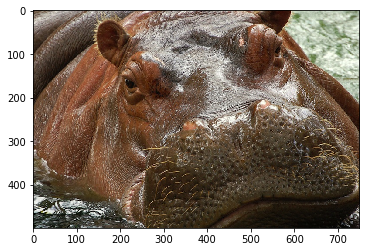

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/nondog3.jpg


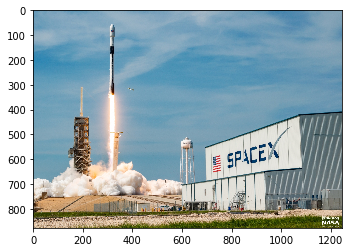

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/dog1_dalmatian.jpg


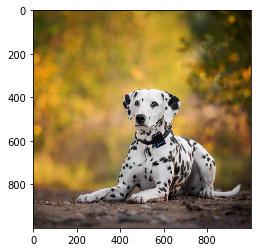

	- This is dog of breed: Dalmatian
-------------------------------------
Making prediction for: data/test_images/dog2_pug.jpg


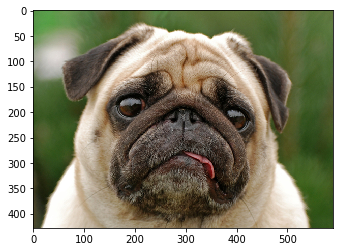

	- This is dog of breed: Bulldog
-------------------------------------
Making prediction for: data/test_images/nondog2.jpg


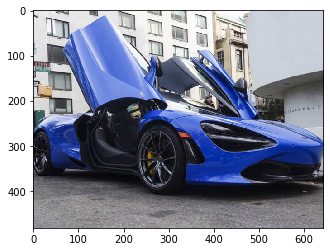

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/nondog10.png


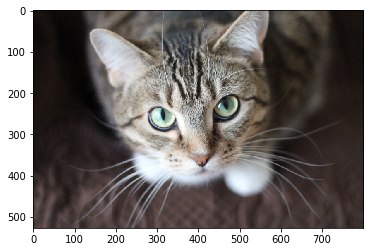

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/nondog5.jpeg


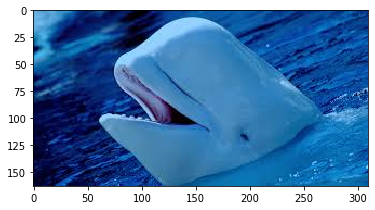

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/nondog4.jpeg


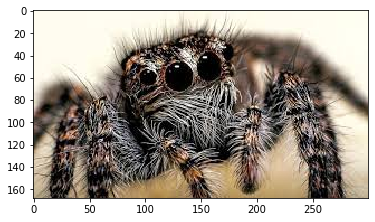

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/nondog6.png


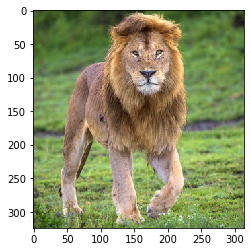

	- This is human that looks like dog of breed: Chow_chow
-------------------------------------
Making prediction for: data/test_images/person2.jpg


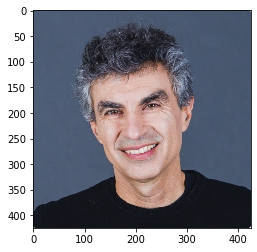

	- This is human that looks like dog of breed: Briard
-------------------------------------
Making prediction for: data/test_images/person1.jpg


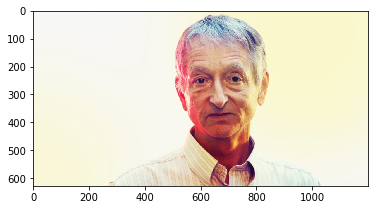

	- This is human that looks like dog of breed: Yorkshire_terrier
-------------------------------------
Making prediction for: data/test_images/person4.png


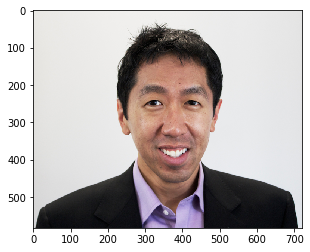

	- This is human that looks like dog of breed: Portuguese_water_dog
-------------------------------------
Making prediction for: data/test_images/nondog8.jpg


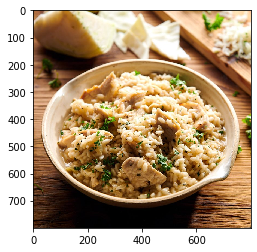

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/dog3_doberman.jpg


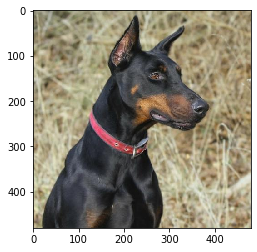

	- This is dog of breed: Doberman_pinscher
-------------------------------------
Making prediction for: data/test_images/person3.png


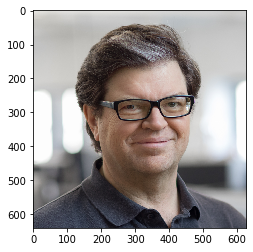

	- This is human that looks like dog of breed: Portuguese_water_dog
-------------------------------------
Making prediction for: data/test_images/person5.jpg


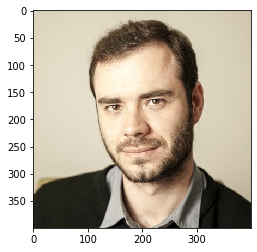

	- This is human that looks like dog of breed: Lowchen
-------------------------------------
Making prediction for: data/test_images/nondog7.jpeg


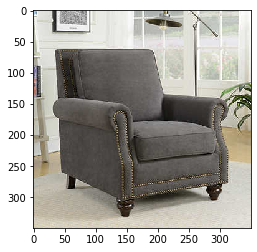

	- This is neither dog or human.
-------------------------------------
Making prediction for: data/test_images/dog5_siberian_husky.jpg


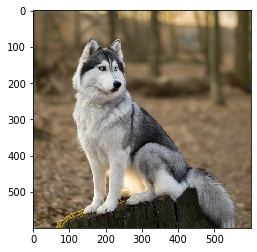

	- This is dog of breed: Alaskan_malamute
-------------------------------------
Making prediction for: data/test_images/dog4_golden_retriever.jpg


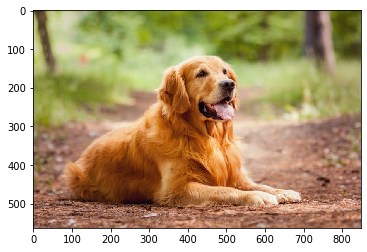

	- This is dog of breed: Golden_retriever
-------------------------------------
Making prediction for: data/test_images/nondog1.jpg


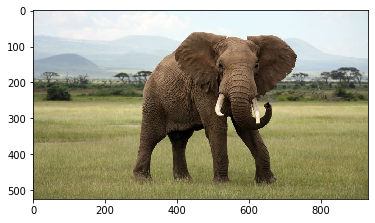

	- This is neither dog or human.
-------------------------------------


In [34]:
for img_name in os.listdir(TEST_IMAGES_DIR):
    img_filepath = os.path.join(TEST_IMAGES_DIR, img_name)
    system.predict(img_filepath, plot=True, verbose=True)
    print("-------------------------------------")

## Conclusions

---
### The system is a connection of three models:

1. **Human Predictor** - Haar Cascade `haarcascade_frontalface_alt` included in OpenCV library. It is capable of detecting human faces. When human face is found on the images, then classifier flags that human can be also found on the image. It is quite naive solution but suprisingly gives `f1_score` of value **0.938** on testing dataset constructed from 500 human images and 500 dog images. Other facial cascades were tested too but selected one gave best results. It is also important to note that some dog images contain humans and this is the main weakness of this solution. Apart from that is quite straightforward and lightweight.


2. **Dog Predictor** - `ResNet50 which` is just loaded set of network weights from Keras library. Luckily `ResNet50` was trained on many anmial images. It is capable of detecting various dog breeds and because of that it can be used as dog detector. If for given dog image it returns a class corresponding to dog breed then it is possible to say that the dog is present on the image. Even if dog from unkown to ResNet50 breed is used for prediction it should still give dog breed class most similar to the given dog (as dogs are in general similar to each other). So in this case training of model was not needed. Model has great performance of `f1_score` value equal to **0.987**. Tested on dataset constructed from 500 human images and 500 dog images it managed to correctly detect 492 dogs and correclty ignore 496 people. Further investigation could be made to see on which human images network managed to fail. Maybe there was a human with a dog or some dog in background.


3. **Dog Breed Predictor** - finetuned neural network of `InceptionV3` architecture. InceptionV3 was loaded with "imagenet" weights through Keras library. Top with dense layers was thrown away and the rest was frozen. New top of neural network was constructed from `GlobalAveragePooling2D` layer and Dense layer with softmax output. It is to train neural network the new outputs which are dog breeds. Apart from `InceptionV3`, architectures like `VGG16` and `VGG19` were also tested. Best architecture was picked and the result is `f1_score` value of **0.785** on testing dataset - not available to network during training process.
---

### Self-made test dataset results
To see how model performs on different images than humans and dogs, 20 images were picked from google search. It is of course very small amount and not enough to say if the performance is for sure good. But few conclusions can be made:

1. System was always able to correctly detect dogs and humans.
2. System made three mistakes:
    - mistaken Pug for Bulldog - and this might be because pug image is zoomed and it is actually similar to bulldog if you check how bullldog looks like,
    - mistaken Siberian Husky for Alaskan Malamute - again close mistake, both dogs are the same color and I personally cannot tell them apart, image of Siberian Husky has some additional lighting on the dog,
    - mistaken Lion for Chow Chow - and that one is my favourite mistake that model has made, it shows that it really picks up the similarity

<img src="https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/chow-chow-card-small.jpg?bust=1535568975g"
    width="500px"/>

<img src="https://steelburgernews.co.za/wp-content/uploads/sites/47/2019/02/male-lion-big-cat-sanctuary-uhd-4k-wallpaper.jpg"
    width="500px"/>
    
3. Comparison of Yoshua Bengio to Briard and Yan Lecun to Portugese Water Dog was somehow accurate.

---
### Potential improvements

#### Machine Learning side
1. **Architectures** 
    It is important to note that current system is just a prototype, a showcase what could be done and improved in the future. The human data was not used at all in any case to teach model how to detect them. Deep learning model could be produced. I tried to play with finetuning https://github.com/rcmalli/keras-vggface but first results didn't go well and I had to make the deadline. But for sure network which is having more knowledge about how people looks like would be more stable predictor. The same goes for dog predictor. Usage of ResNet50 is just a workaround. It is not a model which was taught to especially to detect dogs.
    
    
2. **Data Amount**
    There was ~8800 dog images. There are a lot of other datasets available with dogs. It is quite easy to get more data and make even better model. Same goes to human dataset. There are datasets meant for face detection or image generation (e.g. http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html has 200k human images). 
    
    
3. **Data Quality**
    Despite having small amount images there were cases where people were together with dogs or dogs with various breeds on the same image. Such images should be removed in current system setup.
    
    
4. **Weak Point Analysis**
    It is important to look how model performs on each class and which classes are mixed together. For example Pug and Bulldog error case has shown that network might need more zoomed images of Pugs and Bulldogs because if it doesn't see whole dog then it is easy to make mistake just by looking at face. Similar analysis could be done for more images.
    
    
5. **System Complexity**
    This is a very basic setup that is unable to classify images with many dogs or dogs and people. First data segmentation could be performed with some strong neural networks like Faster RCNN ResNet 101 or others (e.g. available here https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Of course it is a challenge to find the data which has boundary boxes attached to it. Still if such data would be found the segmentation on humans and dogs could be performed. Cropped images could go to Dog Breed predictor for output. Then it is possible for system to give multiple outputs for many different dogs/humans on the same images.

#### Engineering side
1. **RAM Efficiency**
    Currently this notebook works because image datasets are small. When training neural networks all data was saved into memory. PC with RAM size 16GB started using SWAP memory anyway. And there were only 8800 images loaded. To avoid such memory load, batches should be constructed from image urls and only this batch should be loaded. Also batch size could be reduced.
2. **Code Structure**
    Usage of Predictor class made importing/exporting of the model quite hard. It is good for comparing models and comfortable to work with. I wonder if KerasWrappers and saving whole model predict process to sklearn's Pipeline wouldn't be more effective. Then model could be pickled with the rest of it's functions.
3. **Project Structure**
    All code should be moved to .py files in `project` folder. Notebook should use only imports. As all functions are in this notebook it became very hard to work with and read. 